## IMPORTS 

In [1]:
import time
import pandas as pd
import numpy as np
import re
import torch
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')

import torch.nn as nn
import torch.nn.functional as F

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [2]:
embed_size = 300
max_features = 70000
maxlen = 600
batch_size = 512
SEED = 12

In [3]:
columns = ['id','entity', 'label', 'tweet']
train_data = pd.read_csv('datasets/twitter_training.csv', names=columns, header=None)
test_data = pd.read_csv('datasets/twitter_validation.csv', names=columns, header=None)
data = pd.concat([train_data, test_data])[['tweet', 'entity', 'label']]
data = data[pd.notnull(data['tweet'])]
data['entity'].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [4]:
count_df = data[['label','tweet']].groupby('label').aggregate({'tweet':'count'}).reset_index().sort_values('tweet',ascending=False)
count_df.head()

,label,tweet
1,Negative,22624
3,Positive,20932
2,Neutral,18393
0,Irrelevant,13047


In [5]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    x = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [6]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [7]:
data['tweet'] = data['tweet'].apply(lambda x: x.lower())
# data['tweet'] = data['tweet'].apply(lambda x: clean_text(x))
data['tweet'] = data['tweet'].apply(lambda x: clean_numbers(x))
data['tweet'] = data['tweet'].apply(lambda x: replace_contractions(x))
data['entity'] = data['entity'].apply(lambda x: x.lower())
# data['entity'] = data['entity'].apply(lambda x: clean_text(x))
data['entity'] = data['entity'].apply(lambda x: clean_numbers(x))

In [8]:
data['tweet'] = data['entity'] + ' ' + data['tweet']

In [9]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['tweet'], data['label'],
                                                    stratify=data['label'], 
                                                    test_size=0.25)

In [10]:
print('Train shape : ', train_X.shape)
print('Test shape : ', test_X.shape)

Train shape :  (56247,)
Test shape :  (18749,)


In [11]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

In [13]:
# https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'trash/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding='utf8'))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [14]:
embedding_matrix = load_glove(tokenizer.word_index)

C:\Users\lolit\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
np.shape(embedding_matrix)

(31047, 300)

In [16]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title('Train/Validation Loss')
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [20]:
class BiLSTM(nn.Module):
    
    def __init__(self, hidden_size=64, dropout=0.1):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        drp = dropout
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        # print('h_embedding:', h_embedding.shape) [512, 600, 300]
        h_lstm, _ = self.lstm(h_embedding) 
        # print('h_lstm:', h_lstm.shape) [512, 600, 128]
        avg_pool = torch.mean(h_lstm, 1)
        # print('avg_pool:', avg_pool.shape) [512, 128]
        max_pool, _ = torch.max(h_lstm, 1)
        # print('max_pool:', max_pool.shape) [512, 128]
        conc = torch.cat(( avg_pool, max_pool), 1)
        # print('conc:', conc.shape) [512, 256]
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [21]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
model
# .cuda()

x_train = torch.tensor(train_X, dtype=torch.long)
# .cuda()
y_train = torch.tensor(train_y, dtype=torch.long)
# .cuda()
x_cv = torch.tensor(test_X, dtype=torch.long)
# .cuda()
y_cv = torch.tensor(test_y, dtype=torch.long)
# .cuda()

train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    # doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

110it [18:50, 10.28s/it]
<ipython-input-21-565b76a9bdc9>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=542.5333 	 val_loss=428.3482  	 val_acc=0.6630  	 time=1295.70s


110it [24:12, 13.20s/it]


Epoch 2/6 	 loss=362.4370 	 val_loss=309.9456  	 val_acc=0.7697  	 time=1655.89s


110it [29:09, 15.91s/it]


Epoch 3/6 	 loss=239.4605 	 val_loss=249.3351  	 val_acc=0.8166  	 time=2063.57s


110it [35:51, 19.56s/it]


Epoch 4/6 	 loss=167.1190 	 val_loss=214.9726  	 val_acc=0.8484  	 time=2527.11s


96it [30:55, 11.25s/it]

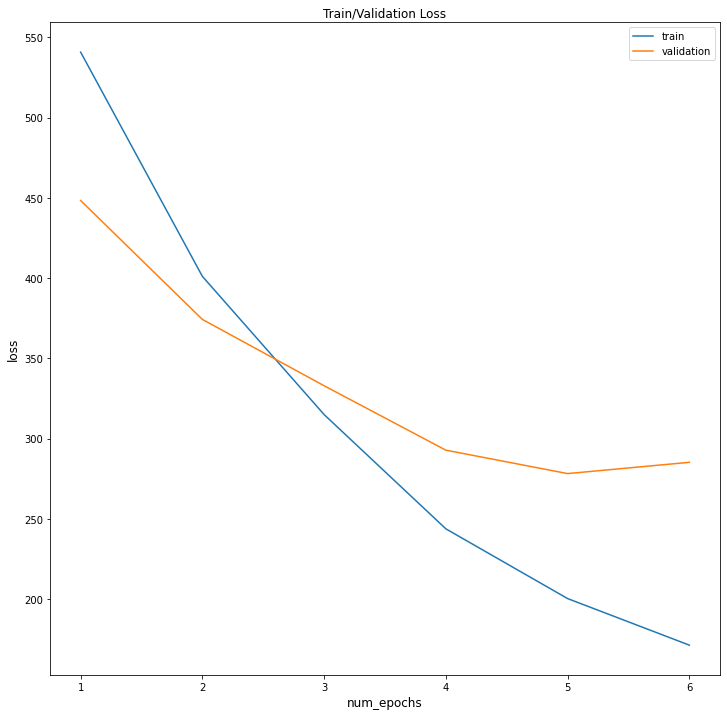

In [ ]:
plot_graph(n_epochs)

In [ ]:
torch.save(model,'bilstm_model_3')

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

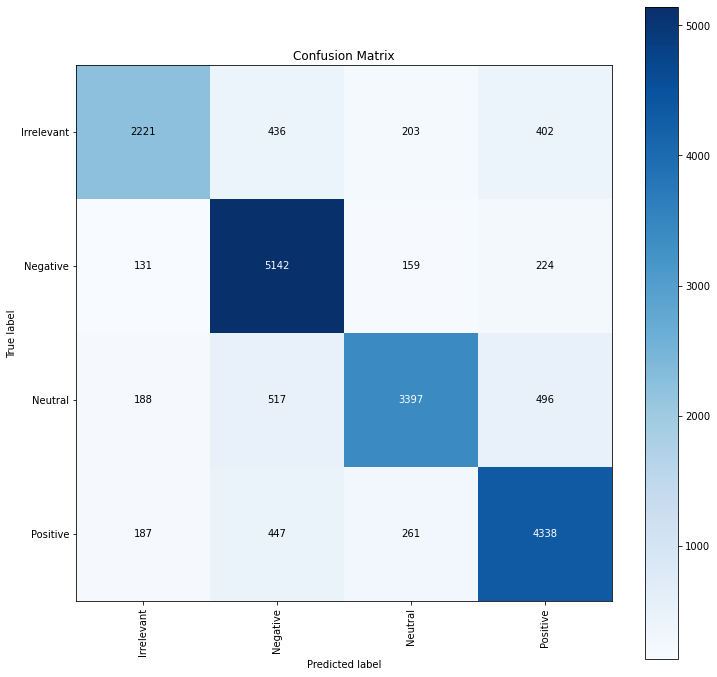

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
def predict_tweet(x):    
    x = x.lower()
    x =  clean_text(x)
    x =  clean_numbers(x)
    x = replace_contractions(x)
    x = tokenizer.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=maxlen)
    x = torch.tensor(x, dtype=torch.long)
    # .cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)
    pred = le.classes_[pred]
    return pred[0]

In [ ]:
x = data['tweet'].values[15]
print(x)

borderlands rockhard la vita rare but powerful handsome jackpot borderlands 1 xbox dlvritrmtrgf


In [ ]:
predict_tweet(x)

<ipython-input-46-1f323e18a200>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred).cpu().numpy()


'Neutral'